# Philmore Koung, pfk180000
## Data From
###  vishal subbiah_2018,
###	title={Pokemon Image Dataset},
###	url={https://www.kaggle.com/datasets/vishalsubbiah/pokemon-images-and-types/data},
###	DOI={10.34740/KAGGLE/DSV/215866},
###	publisher={Kaggle},
###	author={vishal subbiah},
###	year={2018}

In [1]:
#pip install opencv-python
#pip install tensorflow
csv_id = '12NQClwS86x4KfGBImAMadRxwB_sUchxz'
download_link = f'https://drive.google.com/uc?id={csv_id}'

In [2]:
import requests
from io import BytesIO
from zipfile import ZipFile
from keras.models import Model
from keras.layers import Dense, Conv2D, Activation, Flatten, MaxPooling2D, Dropout, Dense
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import gdown
import zipfile
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.applications import MobileNetV2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


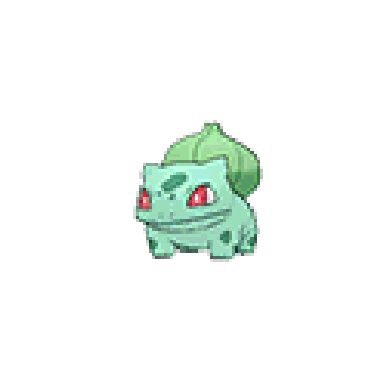

In [3]:
# URL of the zipfile on GitHub
zip_url = 'https://github.com/philmorefkoung/Deep-Learning-Using-Keras/raw/main/images.zip'

# Get the content of the zipfile

response = requests.get(zip_url, allow_redirects=True)
stuff_content = BytesIO(response.content)

# Extract the zipfile
with ZipFile(stuff_content) as z:
    z.extractall()
# Now, the images are extracted to the current directory and you can load them as needed
import matplotlib.pyplot as plt
from PIL import Image

image_path = "images/bulbasaur.png"
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')  # To hide axes
plt.show()


# Loading and Pre-processing

In [4]:
df = pd.read_csv(download_link)
print(df.head())
image_paths = [name + '.png' for name in df['Name']]

         Name  Type1   Type2
0   bulbasaur  Grass  Poison
1     ivysaur  Grass  Poison
2    venusaur  Grass  Poison
3  charmander   Fire     NaN
4  charmeleon   Fire     NaN


In [5]:
df['Type1'].unique()

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric',
       'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice',
       'Dragon', 'Dark', 'Steel', 'Flying'], dtype=object)

In [6]:
print(image_paths)

['bulbasaur.png', 'ivysaur.png', 'venusaur.png', 'charmander.png', 'charmeleon.png', 'charizard.png', 'squirtle.png', 'wartortle.png', 'blastoise.png', 'caterpie.png', 'metapod.png', 'butterfree.png', 'weedle.png', 'kakuna.png', 'beedrill.png', 'pidgey.png', 'pidgeotto.png', 'pidgeot.png', 'rattata.png', 'raticate.png', 'spearow.png', 'fearow.png', 'ekans.png', 'arbok.png', 'pikachu.png', 'raichu.png', 'sandshrew.png', 'sandslash.png', 'nidoran-f.png', 'nidorina.png', 'nidoqueen.png', 'nidoran-m.png', 'nidorino.png', 'nidoking.png', 'clefairy.png', 'clefable.png', 'vulpix.png', 'ninetales.png', 'jigglypuff.png', 'wigglytuff.png', 'zubat.png', 'golbat.png', 'oddish.png', 'gloom.png', 'vileplume.png', 'paras.png', 'parasect.png', 'venonat.png', 'venomoth.png', 'diglett.png', 'dugtrio.png', 'meowth.png', 'persian.png', 'psyduck.png', 'golduck.png', 'mankey.png', 'primeape.png', 'growlithe.png', 'arcanine.png', 'poliwag.png', 'poliwhirl.png', 'poliwrath.png', 'abra.png', 'kadabra.png', 'al

In [7]:
# Create multi-labels for each Pokemon
df['Types'] = df.apply(lambda row: [row['Type1']] if pd.isnull(row['Type2']) else [row['Type1'], row['Type2']], axis=1)

mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(df['Types'])
labels = np.array(labels)

In [8]:
images_list = []
valid_names = []

for img_path in image_paths:
    img = cv2.imread('images/' + img_path)
    if img is not None:
        resized_img = cv2.resize(img, (224, 224))
        images_list.append(resized_img)
        valid_names.append(img_path.replace('.png', ''))

images = np.array(images_list)        

In [9]:
df_filtered = df[df['Name'].isin(valid_names)]
labels_filtered = mlb.transform(df_filtered['Types'])
images_array = np.array(images_list)


In [10]:
print(images_array.shape)
print(labels_filtered.shape)

(721, 224, 224, 3)
(721, 18)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(images_array, labels_filtered, test_size=0.4, random_state=42)

In [12]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Get output from base model
x = base_model.output

# Add a custom convolutional layer
x = Conv2D(128, kernel_size=(1, 1), padding='same')(x)
x = Activation('relu')(x)

# Optionally add a MaxPooling layer to reduce spatial dimensions
x = MaxPooling2D(pool_size=(2, 2))(x)

# Flatten the 2D feature maps to 1D vector before passing to Dense layer
x = Flatten()(x)

# Continue with the Dense layers
x = Dense(512, activation='relu')(x)
predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)  # Multi-label (k-hot encoding)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers of the base model to reduce overfitting
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fine Tuning

In [13]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=32)


Epoch 1/15
14/14 [==============================] - 16s 1s/step - loss: 0.4936 - accuracy: 0.0625 - val_loss: 0.3003 - val_accuracy: 0.0900
Epoch 2/15
14/14 [==============================] - 13s 949ms/step - loss: 0.2725 - accuracy: 0.1759 - val_loss: 0.2816 - val_accuracy: 0.1246
Epoch 3/15
14/14 [==============================] - 13s 936ms/step - loss: 0.2426 - accuracy: 0.2176 - val_loss: 0.2822 - val_accuracy: 0.1142
Epoch 4/15
14/14 [==============================] - 13s 948ms/step - loss: 0.2104 - accuracy: 0.3542 - val_loss: 0.2844 - val_accuracy: 0.1211
Epoch 5/15
14/14 [==============================] - 13s 934ms/step - loss: 0.1736 - accuracy: 0.4583 - val_loss: 0.2999 - val_accuracy: 0.1453
Epoch 6/15
14/14 [==============================] - 13s 950ms/step - loss: 0.1340 - accuracy: 0.6134 - val_loss: 0.3130 - val_accuracy: 0.1592
Epoch 7/15
14/14 [==============================] - 13s 930ms/step - loss: 0.1046 - accuracy: 0.6644 - val_loss: 0.3160 - val_accuracy: 0.1972
Ep

In [14]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

In [15]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
14/14 [==============================] - 13s 984ms/step - loss: 0.0028 - accuracy: 0.7917 - val_loss: 0.5477 - val_accuracy: 0.1799
Epoch 2/10
14/14 [==============================] - 13s 977ms/step - loss: 0.0023 - accuracy: 0.7685 - val_loss: 0.5552 - val_accuracy: 0.1834
Epoch 3/10
14/14 [==============================] - 14s 993ms/step - loss: 0.0019 - accuracy: 0.7431 - val_loss: 0.5695 - val_accuracy: 0.1799
Epoch 4/10
14/14 [==============================] - 13s 982ms/step - loss: 0.0016 - accuracy: 0.7500 - val_loss: 0.5786 - val_accuracy: 0.1799
Epoch 5/10
14/14 [==============================] - 13s 987ms/step - loss: 0.0014 - accuracy: 0.7292 - val_loss: 0.5887 - val_accuracy: 0.1799
Epoch 6/10
14/14 [==============================] - 13s 980ms/step - loss: 0.0012 - accuracy: 0.7477 - val_loss: 0.5977 - val_accuracy: 0.1869
Epoch 7/10
14/14 [==============================] - 13s 992ms/step - loss: 0.0011 - accuracy: 0.7269 - val_loss: 0.6041 - val_accuracy: 0.1730

In [16]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)

Epoch 1/5
14/14 [==============================] - 13s 974ms/step - loss: 7.3398e-04 - accuracy: 0.7060 - val_loss: 0.6328 - val_accuracy: 0.1765
Epoch 2/5
14/14 [==============================] - 13s 939ms/step - loss: 6.7406e-04 - accuracy: 0.7431 - val_loss: 0.6411 - val_accuracy: 0.1869
Epoch 3/5
14/14 [==============================] - 13s 931ms/step - loss: 6.2064e-04 - accuracy: 0.7315 - val_loss: 0.6475 - val_accuracy: 0.1765
Epoch 4/5
14/14 [==============================] - 13s 943ms/step - loss: 5.8162e-04 - accuracy: 0.7477 - val_loss: 0.6536 - val_accuracy: 0.1903
Epoch 5/5
14/14 [==============================] - 13s 926ms/step - loss: 5.3203e-04 - accuracy: 0.7176 - val_loss: 0.6577 - val_accuracy: 0.1799


In [17]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=16)

Epoch 1/5
27/27 [==============================] - 13s 487ms/step - loss: 4.9958e-04 - accuracy: 0.7569 - val_loss: 0.6677 - val_accuracy: 0.1799
Epoch 2/5
27/27 [==============================] - 13s 478ms/step - loss: 4.3849e-04 - accuracy: 0.7106 - val_loss: 0.6844 - val_accuracy: 0.1869
Epoch 3/5
27/27 [==============================] - 13s 481ms/step - loss: 3.8541e-04 - accuracy: 0.7407 - val_loss: 0.6876 - val_accuracy: 0.1834
Epoch 4/5
27/27 [==============================] - 13s 483ms/step - loss: 3.3758e-04 - accuracy: 0.7546 - val_loss: 0.6968 - val_accuracy: 0.1765
Epoch 5/5
27/27 [==============================] - 13s 472ms/step - loss: 2.9799e-04 - accuracy: 0.7407 - val_loss: 0.7077 - val_accuracy: 0.1799


In [18]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=8)

Epoch 1/5
54/54 [==============================] - 13s 250ms/step - loss: 2.7826e-04 - accuracy: 0.7361 - val_loss: 0.7133 - val_accuracy: 0.1834
Epoch 2/5
54/54 [==============================] - 13s 244ms/step - loss: 2.2880e-04 - accuracy: 0.7593 - val_loss: 0.7334 - val_accuracy: 0.1799
Epoch 3/5
54/54 [==============================] - 13s 247ms/step - loss: 1.8193e-04 - accuracy: 0.7523 - val_loss: 0.7487 - val_accuracy: 0.1730
Epoch 4/5
54/54 [==============================] - 13s 244ms/step - loss: 1.5347e-04 - accuracy: 0.7407 - val_loss: 0.7581 - val_accuracy: 0.1765
Epoch 5/5
54/54 [==============================] - 13s 246ms/step - loss: 1.3010e-04 - accuracy: 0.7384 - val_loss: 0.7775 - val_accuracy: 0.1938


In [19]:
model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=8)

Epoch 1/5
54/54 [==============================] - 16s 255ms/step - loss: 1.1206e-04 - accuracy: 0.7569 - val_loss: 0.7775 - val_accuracy: 0.1903
Epoch 2/5
54/54 [==============================] - 13s 240ms/step - loss: 1.1131e-04 - accuracy: 0.7593 - val_loss: 0.7776 - val_accuracy: 0.1903
Epoch 3/5
54/54 [==============================] - 13s 243ms/step - loss: 1.1066e-04 - accuracy: 0.7593 - val_loss: 0.7777 - val_accuracy: 0.1903
Epoch 4/5
54/54 [==============================] - 13s 245ms/step - loss: 1.1011e-04 - accuracy: 0.7593 - val_loss: 0.7778 - val_accuracy: 0.1903
Epoch 5/5
54/54 [==============================] - 13s 245ms/step - loss: 1.0964e-04 - accuracy: 0.7593 - val_loss: 0.7778 - val_accuracy: 0.1903


# 1x1

In [20]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Get output from base model
x = base_model.output

# Add a custom convolutional layer
x = Conv2D(128, kernel_size=(1, 1), padding='same')(x)
x = Activation('relu')(x)

# Optionally add a MaxPooling layer to reduce spatial dimensions
x = MaxPooling2D(pool_size=(2, 2))(x)

# Flatten the 2D feature maps to 1D vector before passing to Dense layer
x = Flatten()(x)

# Continue with the Dense layers
x = Dense(512, activation='relu')(x)
predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)  # Multi-label (k-hot encoding)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers of the base model to reduce overfitting
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=8)

Epoch 1/5
54/54 [==============================] - 16s 260ms/step - loss: 0.3470 - accuracy: 0.0972 - val_loss: 0.2893 - val_accuracy: 0.1038
Epoch 2/5
54/54 [==============================] - 13s 249ms/step - loss: 0.2369 - accuracy: 0.2500 - val_loss: 0.2859 - val_accuracy: 0.1592
Epoch 3/5
54/54 [==============================] - 13s 246ms/step - loss: 0.1780 - accuracy: 0.4444 - val_loss: 0.2998 - val_accuracy: 0.1315
Epoch 4/5
54/54 [==============================] - 13s 249ms/step - loss: 0.1132 - accuracy: 0.6204 - val_loss: 0.3232 - val_accuracy: 0.1765
Epoch 5/5
54/54 [==============================] - 13s 247ms/step - loss: 0.0574 - accuracy: 0.7384 - val_loss: 0.3770 - val_accuracy: 0.1419


# 5x5

In [22]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Get output from base model
x = base_model.output

# Add a custom convolutional layer
x = Conv2D(128, kernel_size=(5, 5), padding='same')(x)
x = Activation('relu')(x)

# Add a MaxPooling layer to reduce spatial dimensions
x = MaxPooling2D(pool_size=(2, 2))(x)

# Flatten the 2D feature maps to 1D vector before passing to Dense layer
x = Flatten()(x)

# Continue with the Dense layers
x = Dense(512, activation='relu')(x)
predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)  # Multi-label (k-hot encoding)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers of the base model to reduce overfitting
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=8)

Epoch 1/5
54/54 [==============================] - 23s 382ms/step - loss: 0.6419 - accuracy: 0.0648 - val_loss: 0.2940 - val_accuracy: 0.1280
Epoch 2/5
54/54 [==============================] - 20s 368ms/step - loss: 0.2599 - accuracy: 0.1852 - val_loss: 0.3017 - val_accuracy: 0.1142
Epoch 3/5
54/54 [==============================] - 20s 368ms/step - loss: 0.2242 - accuracy: 0.2801 - val_loss: 0.2836 - val_accuracy: 0.1592
Epoch 4/5
54/54 [==============================] - 20s 369ms/step - loss: 0.1761 - accuracy: 0.3889 - val_loss: 0.3187 - val_accuracy: 0.1661
Epoch 5/5
54/54 [==============================] - 20s 369ms/step - loss: 0.1336 - accuracy: 0.5648 - val_loss: 0.3339 - val_accuracy: 0.1384


# 5 layers (3CNN, 1 maxpooling, 1 dropout)

In [23]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Get output from base model
x = base_model.output

# Add the first custom convolutional layer
x = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(x)

# Add the second custom convolutional layer
x = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(x)

# Add the third custom convolutional layer
x = Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu')(x)

# Add a MaxPooling layer to reduce spatial dimensions
x = MaxPooling2D(pool_size=(2, 2))(x)

# Add a dropout layer
x = Dropout(0.5)(x)

# Flatten the 2D feature maps to 1D vector before passing to Dense layer
x = Flatten()(x)

# Continue with the Dense layers
x = Dense(512, activation='relu')(x)
predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)  # Multi-label (k-hot encoding)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers of the base model to reduce overfitting
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=8)


Epoch 1/5
54/54 [==============================] - 19s 299ms/step - loss: 0.3163 - accuracy: 0.0741 - val_loss: 0.2885 - val_accuracy: 0.0588
Epoch 2/5
54/54 [==============================] - 15s 287ms/step - loss: 0.2817 - accuracy: 0.1065 - val_loss: 0.2937 - val_accuracy: 0.1142
Epoch 3/5
54/54 [==============================] - 15s 282ms/step - loss: 0.2772 - accuracy: 0.1181 - val_loss: 0.2887 - val_accuracy: 0.0727
Epoch 4/5
54/54 [==============================] - 15s 285ms/step - loss: 0.2596 - accuracy: 0.1667 - val_loss: 0.2928 - val_accuracy: 0.1696
Epoch 5/5
54/54 [==============================] - 15s 282ms/step - loss: 0.2431 - accuracy: 0.2292 - val_loss: 0.2854 - val_accuracy: 0.1522


In [24]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

In [25]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Get output from base model
x = base_model.output

# Add a custom convolutional layer
x = Conv2D(128, kernel_size=(3, 3), padding='same')(x)
x = Activation('relu')(x)

# Optionally add a MaxPooling layer to reduce spatial dimensions
x = MaxPooling2D(pool_size=(2, 2))(x)

# Flatten the 2D feature maps to 1D vector before passing to Dense layer
x = Flatten()(x)

# Continue with the Dense layers
x = Dense(512, activation='relu')(x)
predictions = Dense(len(mlb.classes_), activation='softmax')(x)  # Multi-label (k-hot encoding)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers of the base model to reduce overfitting
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=8)

Epoch 1/5
54/54 [==============================] - 19s 300ms/step - loss: 60.6808 - accuracy: 0.0764 - val_loss: 288.0726 - val_accuracy: 0.0415
Epoch 2/5
54/54 [==============================] - 15s 279ms/step - loss: 2123.4443 - accuracy: 0.0602 - val_loss: 5674.3286 - val_accuracy: 0.1038
Epoch 3/5
54/54 [==============================] - 15s 283ms/step - loss: 21767.0469 - accuracy: 0.0833 - val_loss: 42966.3555 - val_accuracy: 0.1038
Epoch 4/5
54/54 [==============================] - 15s 283ms/step - loss: 68380.5234 - accuracy: 0.0463 - val_loss: 125603.7266 - val_accuracy: 0.0554
Epoch 5/5
54/54 [==============================] - 15s 284ms/step - loss: 169182.0781 - accuracy: 0.0602 - val_loss: 221127.1719 - val_accuracy: 0.0104


In [27]:
# Use MobileNetV2 as the base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Get output from base model
x = base_model.output

# Add a custom convolutional layer
x = Conv2D(128, kernel_size=(3, 3), padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)

# Assuming multi-class classification with softmax activation
predictions = Dense(len(mlb.classes_), activation='tanh')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers of the base model to reduce overfitting
for layer in base_model.layers:
    layer.trainable = False

# Use categorical crossentropy as the loss function for multi-class classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=8)


Epoch 1/5
54/54 [==============================] - 18s 299ms/step - loss: 1.2968 - accuracy: 0.0810 - val_loss: 1.2713 - val_accuracy: 0.0796
Epoch 2/5
54/54 [==============================] - 15s 281ms/step - loss: 1.9307 - accuracy: 0.0463 - val_loss: 2.0426 - val_accuracy: 0.0415
Epoch 3/5
54/54 [==============================] - 15s 285ms/step - loss: 2.0339 - accuracy: 0.0509 - val_loss: 2.0426 - val_accuracy: 0.0415
Epoch 4/5
54/54 [==============================] - 15s 283ms/step - loss: 2.0339 - accuracy: 0.0509 - val_loss: 2.0426 - val_accuracy: 0.0415
Epoch 5/5
54/54 [==============================] - 15s 284ms/step - loss: 2.0339 - accuracy: 0.0509 - val_loss: 2.0426 - val_accuracy: 0.0415


# Visualizng

### History plot

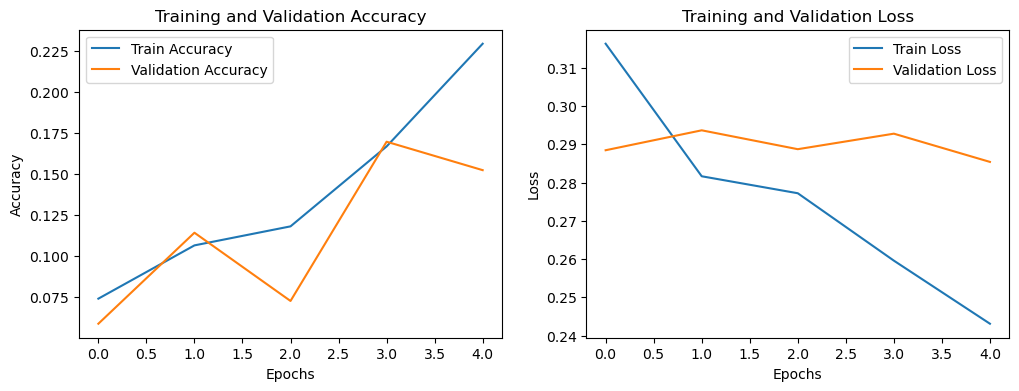

In [28]:
epochs_range = range(len(train_accuracy))

plt.figure(figsize=(12, 4))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracy, label='Train Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

## Filter Visualization

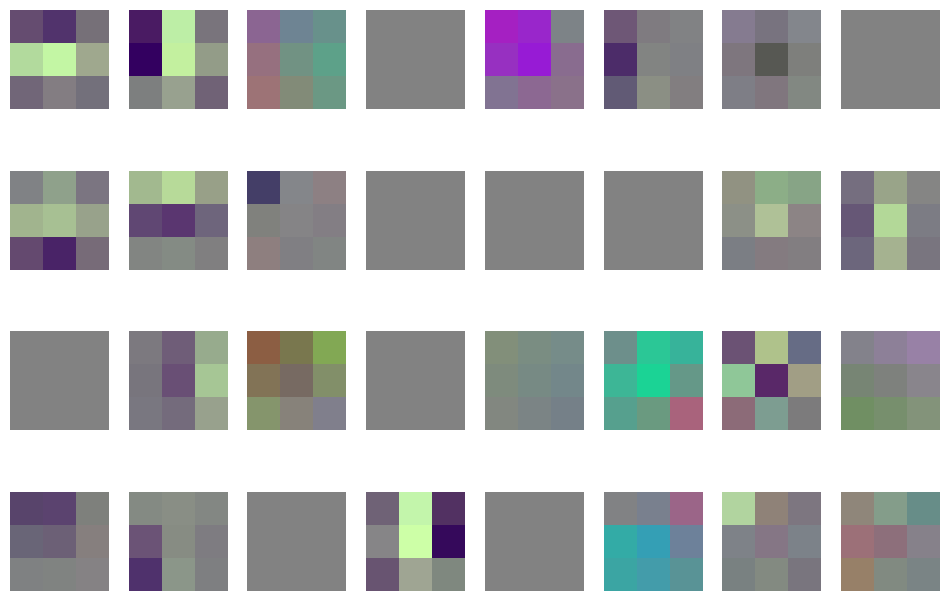

In [29]:
# Extract filters and biases from the desired layer
# Index of the layer you want to visualize
layer_idx = 1  
filters = model.layers[layer_idx].get_weights()[0]

# Normalize filter values between 0 and 1 for visualization
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# Plotting
num_filters = filters.shape[-1]
plt.figure(figsize=(12, 8))

for i in range(num_filters):
    ax = plt.subplot(num_filters // 8, 8, i + 1)
    # Get the ith filter. Adjust the indexing if the channel is first.
    f = filters[:, :, :, i]
    plt.imshow(f)
    ax.axis('off')

plt.show()


## Predicted vs Actual with image

In [30]:
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

10/10 [==============================] - 6s 538ms/step


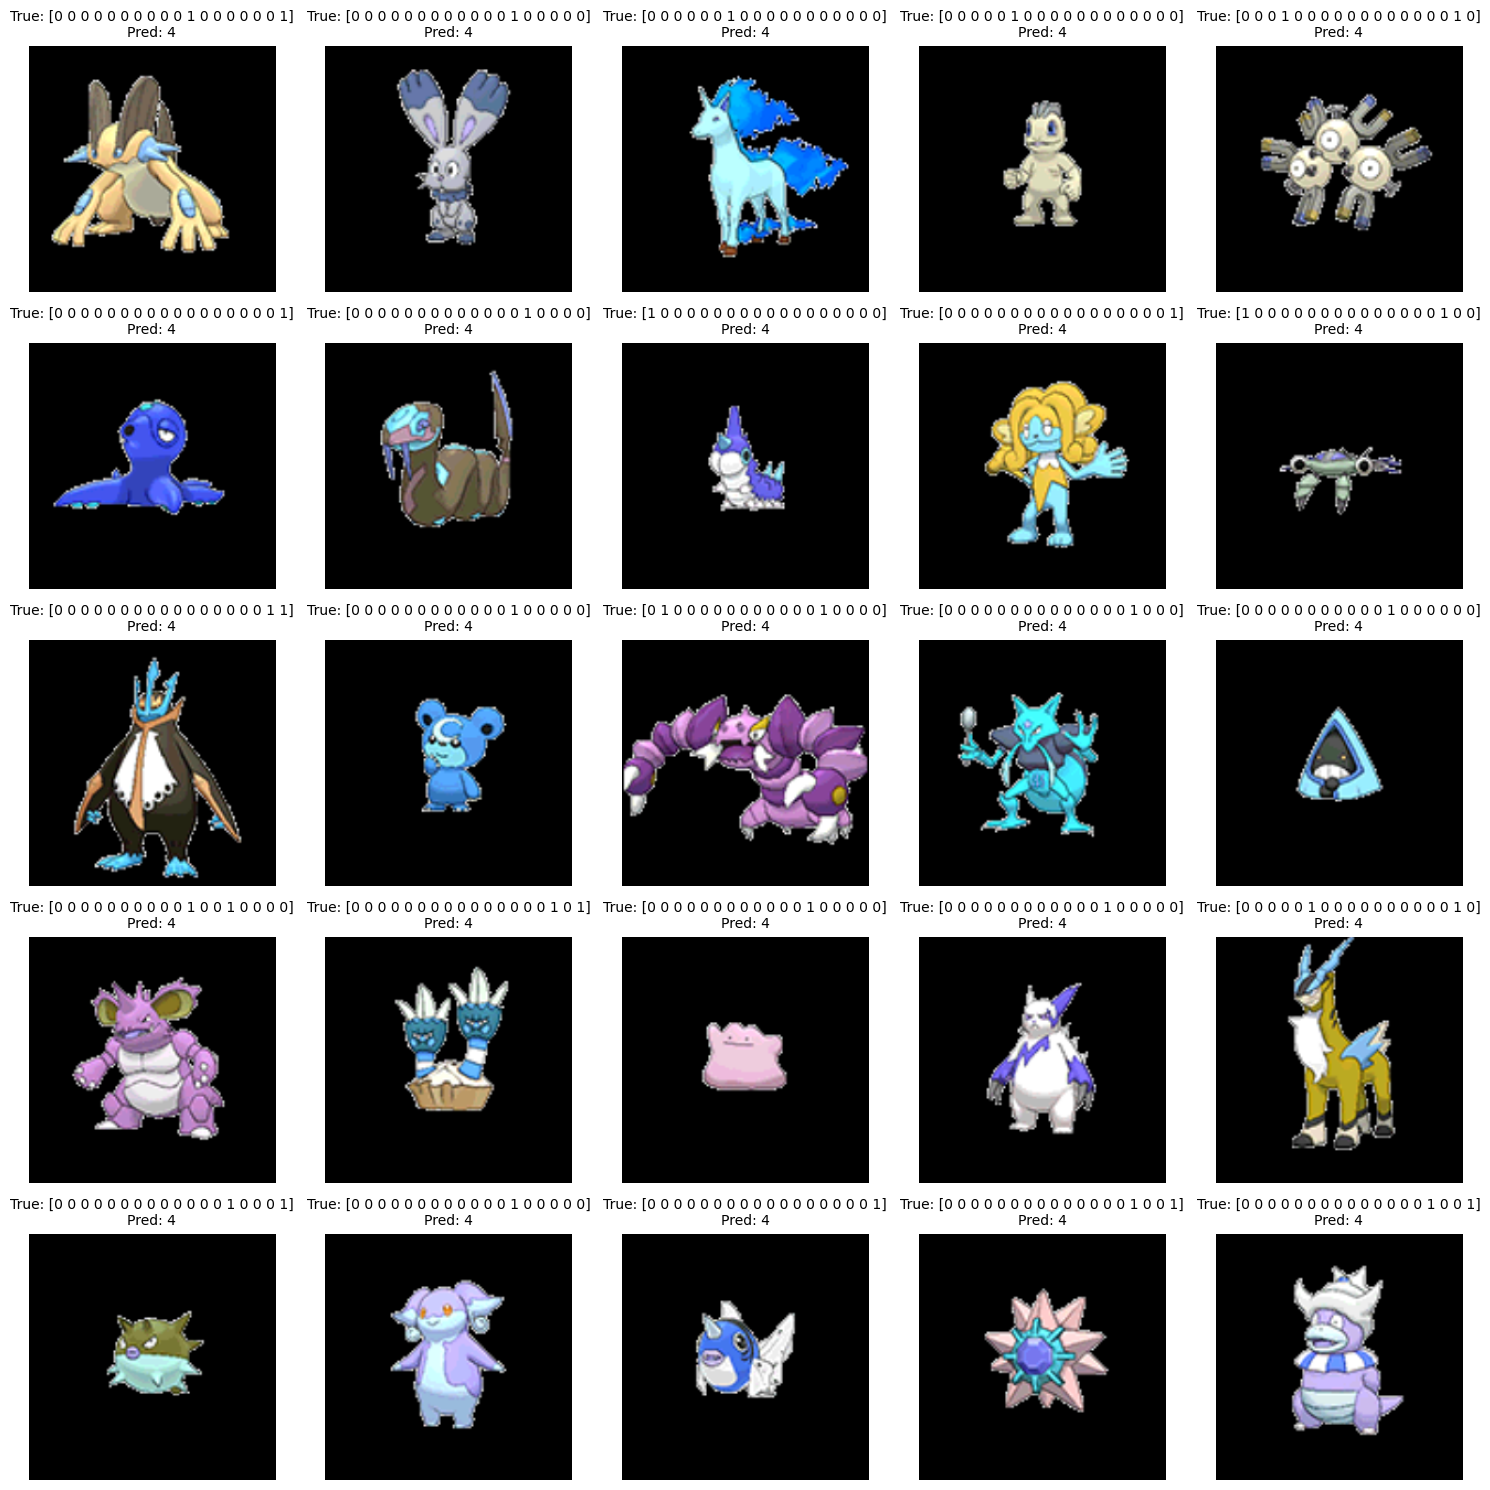

In [31]:
num_images = 25

num_rows = int(np.ceil(num_images / 5))
num_cols = 5

plt.figure(figsize=(15, 3 * num_rows))  

for i in range(num_images):
    plt.subplot(num_rows, num_cols, i + 1) 
    plt.imshow(X_test[i].astype('uint8')) 
    plt.title(f"True: {y_test[i]}\nPred: {predicted_labels[i]}", fontsize=10)  
    plt.axis('off')  # Don't show axis

plt.tight_layout()  
plt.show()

## Parameter testing and tuning

| Iteration | Batch Size |Number of Layers | Filter Size Layer 1 | Activation Function | Optimizer | Training Accuracy | Test Accuracy  |
|-----------|------------|-----------------|---------------------|---------------------|---------- |-------------------|----------------|
| 15        | 326        | 2               | 3x3                 | ReLU                | Adam      | 75.87%            | 20.00%         |
| 10        | 32         | 2               | 3x3                 | ReLU                | Adam      | 73.78%            | 22.07%         |
| 5         | 32         | 2               | 3x3                 | ReLU                | Adam      | 73.96%            | 21.38%         |
| 5         | 16         | 2               | 3x3                 | ReLU                | Adam      | 75.17%            | 21.38%         |
| 5         | 8          | 2               | 3x3                 | ReLU                | Adam      | 74.13%            | 22.07%         |
| 5         | 8          | 2               | 3x3                 | ReLU                | SGD       | 72.74%            | 22.07%         |
| 5         | 8          | 2               | 1x1                 | ReLU                | Adam      | 70.14%            | 14.48%         |
| 5         | 8          | 2               | 5x5                 | ReLU                | Adam      | 49.48%            | 15.17%         |
| 5         | 8          | 5               | 3x3                 | ReLU                | Adam      | 23.61%            | 15.17%         |
| 5         | 8          | 2               | 3x3                 | Softmax             | Adam      | 04.86%            | 04.14%         |
| 5         | 8          | 2               | 3x3                 | tanh                | Adam      | 09.20%            | 08.97%         |
 


In [34]:
'''
given that there are 18 types of pokemon, the expected random guess rate would be 1/18 or 5.56%
our best accuracy is 22.07% which is around 4 times better than random guessing.
The best hyperparameters found were 5 iterations, 8 batch size, 2 layers, 3x3 filer size, ReLU activation, and adam optimizer
this follows the idea of small test/validation tests with multiclassification problem
'''

'\ngiven that there are 18 types of pokemon, the expected random guess rate would be 1/18 or 5.56%\nour best accuracy is 22.07% which is around 4 times better than random guessing.\nThe best hyperparameters found were 5 iterations, 8 batch size, 2 layers, 3x3 filer size, ReLU activation, and adam optimizer\nthis follows the idea of small test/validation tests with multiclassification problem\n'